In [1]:
import pandas as pd
import time
import io
import datetime
import sys
pd.set_option('max_colwidth',150)
%matplotlib inline

### 1.Get the cleaned dataset 

In [2]:
df_titleabstract= pd.read_pickle('df_allword_titleAbstract_supervised.pkl')
df_titleabstract.head(2)

Titre  \
0                       The basics of intravascular optical coherence tomography   
1  An eﬃcient orientation ﬁlter for inertial and inertial/magnetic sensor arrays   

                                                                                                                                                  Resume  \
0  Optical coherence tomography (OCT) has opened new horizons for intravascular coronary imaging. It utilizes near-infrared light to provide a micros...   
1  This report presents a novel orientation ﬁlter applicable to IMUs consisting of tri-axis gyroscopes and accelerometers, and MARG sensor arrays tha...   

                                                     URL  \
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4495121/   
1                                              #item_204   

                   Auteur                     Class  \
0          Roleder Tomasz           Active catheter   
1  Madgwick Sebastian O H  Multi Sensor Data Fusion   

                   ParentClass  \
0  Radiologie interventionelle   
1                           RI   

                                                                                                                                              BagOfWords  
0  basics intravascular optical coherence tomography optical coherence tomography oct opened new horizons intravascular coronary imaging utilizes nea...  
1  eﬃcient orientation ﬁlter inertial inertial magnetic sensor arrays report presents novel orientation ﬁlter applicable imus consisting tri axis gyr...

In [3]:
df_titleabstract.shape

(391, 7)

In [4]:
len(df_titleabstract.ParentClass.unique())

11

In [5]:
uniqueClass=df_titleabstract.ParentClass.unique()
uniqueClass

array(['Radiologie interventionelle', 'RI', 'Navigation hybride',
       "IA pour régulation d'impression 3D", 'G3P-Gravityless3Printing',
       'Par Problème', 'Par Technologie', 'AAP Covid19 armées',
       'R&D_intégrée', 'ARES medica R&D intégrée', 'Biblio KPI EV'],
      dtype=object)

In [6]:
len(df_titleabstract.Class.unique())

40

### 2. Encode the target 

In [7]:
from sklearn import preprocessing
#### Prepare the target and the numerique data
le = preprocessing.LabelEncoder()
df_titleabstract['Target']=le.fit_transform(df_titleabstract.ParentClass)
#df_abstract

### 3. Extract a keyword dictionary that contains the most frequent words in the articles in the three rdf files

In [8]:
import nltk
stop_uk = nltk.corpus.stopwords.words('english')
stop_uk.extend(['paper', 'none', 'image'])

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1,1),stop_words = stop_uk).fit(corpus)
    #vec = CountVectorizer(ngram_range=(2,2),stop_words = stop_uk).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### 4. Split the dataset into train & test, find BOW on train and transform test 

from sklearn.model_selection import train_test_split
def splitDataFrame(df):
    train, test= train_test_split(df, test_size=0.25, random_state=42)
    print(train.shape,'\n')
    print(test.shape,'\n')
    return train,test

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
def splitDataFrame(df,label):
    split=StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)
    for train_index, test_index in split.split(df,label):
        strat_train_set=df_titleabstract.iloc[train_index]
        strat_test_set=df_titleabstract.iloc[test_index]
    print(strat_train_set.shape,'\n')
    print(strat_test_set.shape,'\n')
    return strat_train_set,strat_test_set

In [11]:
train,test=splitDataFrame(df_titleabstract,df_titleabstract.Target)

(273, 8) 

(118, 8) 



### 5.  Get keywords from just train dataset, claculate thier tf-idf values and train ML models on them 

In [12]:
article_common_words = get_top_n_words(train.BagOfWords, 200)
keywords_abstract=[]
for word, freq in article_common_words:
    #print(word, freq)
    keywords_abstract.append(word)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
def calculateTFIDF(train,test,keywords):
    tfidf = TfidfVectorizer(vocabulary=keywords,analyzer='word', ngram_range=(1,1), min_df = 2, stop_words = stop_uk,use_idf=True)
    #tfidf = TfidfVectorizer(vocabulary=keywords,analyzer='word', ngram_range=(2,2), min_df = 2, stop_words = stop_uk,use_idf=True)
    # get matrix of tf-idf values for train
    matrix=tfidf.fit_transform(train.BagOfWords)
    # get features value
    features = tfidf.get_feature_names()
    TfIdf_train = pd.DataFrame(matrix.toarray(),columns=features)
    #Xtrain_TfIdf = pd.DataFrame(matrix,columns=features)
    TfIdf_train.index = train.index
    #TfIdf.head(5)
    train_tfIdf = pd.concat([train, TfIdf_train], axis=1)
    
    # calcul tfIdf for test 
    matrix_test=tfidf.transform(test.BagOfWords)
    # get features value
    features = tfidf.get_feature_names()
    TfIdf_test = pd.DataFrame(matrix_test.toarray(),columns=features)
    #Xtrain_TfIdf = pd.DataFrame(matrix,columns=features)
    TfIdf_test.index = test.index
    #TfIdf.head(5)
    test_tfIdf = pd.concat([test, TfIdf_test], axis=1)
     
    return train_tfIdf,test_tfIdf

###### Get Tf-Idf values for keywords in df_abstract

In [14]:
#df_abstract=calculateTFIDF(df_abstract,keywords_abstract)
train,test=calculateTFIDF(train,test,keywords_abstract)
print(train.shape)
print(test.shape)

(273, 208)
(118, 208)


In [15]:
train.head(2)

Titre  \
107  Dimensional Accuracy and Surface Finish Optimization of Fused Deposition Modelling Parts using Desirability Function Analysis   
4                                                                                (71) Applicant: Voxel8, Inc.. Somerville, MA (US)   

                                                                                                                                                    Resume  \
107  Fused deposition modelling (FDM) machines are increasingly being used to manufacture parts for functional use. The need to ensure that the parts h...   
4    A three-dimensional (3D) printer and method of 3D printing including receiving a 3D model of an object tO be printed, receiving information includ...   

                                                                                                                                                       URL  \
107  http://www.ijert.org/view-pdf/12799/dimensional-accuracy-and-surface-finish-optimization-of-fused-deposition-modelling-parts-using-desirability-fu...   
4                                                                                                                                                 #item_58   

                        Auteur                     Class  \
107  Stephen Oluwashola Akande  Influence des paramètres   
4      Somerville John Minardi     Monitoring impression   

                            ParentClass  \
107  IA pour régulation d'impression 3D   
4    IA pour régulation d'impression 3D   

                                                                                                                                                BagOfWords  \
107  dimensional accuracy surface finish optimization fused deposition modelling parts using desirability function analysis fused deposition modelling ...   
4    applicant inc somerville three dimensional printer method printing including receiving model object printed receiving information including materi...   

     Target  project   process  ...  without  simulation  integrated  state  \
107       4      0.0  0.136524  ...      0.0         0.0         0.0    0.0   
4         4      0.0  0.000000  ...      0.0         0.0         0.0    0.0   

     engineering  context  means  production  ﬂow  fff  
107          0.0      0.0    0.0         0.0  0.0  0.0  
4            0.0      0.0    0.0         0.0  0.0  0.0  

[2 rows x 208 columns]

In [16]:
test.head(2)

Titre  \
61   Textural Analysis-based Online Closed-Loop Quality Control for Additive Manufacturing Processes   
166                   How to improve R&D productivity: the pharmaceutical industry's grand challenge   

                                                                                                                                                    Resume  \
61   Additive manufacturing (AM) is a powerful technology for fabrication of components with complex geometries using a variety of materials. One of th...   
166  The pharmaceutical industry is under growing pressure from a range of environmental issues, including major losses of revenue owing to patent expi...   

                                                           URL  \
61                                                   #item_836   
166  http://www.nature.com/nrd/journal/v9/n3/full/nrd3078.html   

             Auteur                  Class   ParentClass  \
61      Liu Chenang   Défauts géométriques  Par Problème   
166  Paul Steven M.  autre revue et biblio  R&D_intégrée   

                                                                                                                                                BagOfWords  \
61   textural analysis based online closed loop quality control additive manufacturing processes additive manufacturing powerful technology fabrication...   
166  improve productivity pharmaceutical industry grand challenge pharmaceutical industry growing pressure range environmental issues including major l...   

     Target  project   process  ...   without  simulation  integrated  state  \
61        6      0.0  0.159534  ...  0.000000         0.0         0.0    0.0   
166       8      0.0  0.087488  ...  0.157281         0.0         0.0    0.0   

     engineering  context  means  production  ﬂow  fff  
61           0.0      0.0    0.0         0.0  0.0  0.0  
166          0.0      0.0    0.0         0.0  0.0  0.0  

[2 rows x 208 columns]

In [17]:
test.shape

(118, 208)

###  ML  Classification on tf-idf values

In [18]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def prepareDataForML(train,test):
    #y=le.fit_transform(df.Class)
    #print(y.shape)
    #### Split the data into train and test
    X_train=train.drop('Target',axis=1)._get_numeric_data()
    X_test=test.drop('Target',axis=1)._get_numeric_data()
    y_train=train.Target
    y_test=test.Target
    #X.shape
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    print(X_train.shape,'\n')
    print(X_test.shape,'\n')
    print(y_train.shape,'\n')
    print(y_test.shape,'\n')
    return X_train, X_test, y_train, y_test

In [19]:
from sklearn.preprocessing import StandardScaler
def normalizeTrainTest(X_train,X_test):
    # On change le format pour que scikitlearn tourne bien
    train_numpy = X_train.to_numpy()
    scaler=StandardScaler()
    # On centre réduit
    train_std = scaler.fit_transform(train_numpy)
    print(train_std.shape)
    # On change le format pour que scikitlearn tourne bien
    test_numpy = X_test.to_numpy()
    # On centre réduit
    test_std = scaler.transform(test_numpy)
    print(test_std.shape)
    return train_std,test_std

###  Visualize the distribution of classes

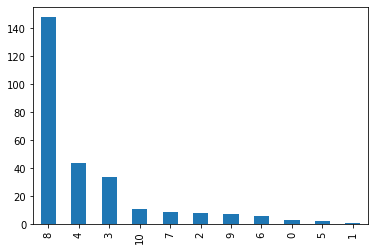

In [20]:
train.Target.value_counts().plot.bar()

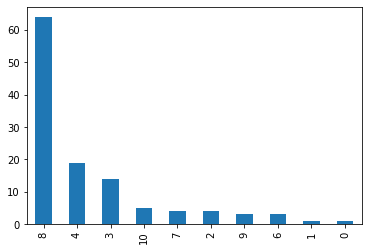

In [21]:
test.Target.value_counts().plot.bar()

#### Split into train, test for the dataset and the target

In [22]:
X_train, X_test, y_train, y_test=prepareDataForML(train,test)

(273, 200) 

(118, 200) 

(273,) 

(118,) 



In [23]:
X_train

project   process  management     based     model   control     using  \
107  0.000000  0.136524    0.000000  0.000000  0.000000  0.000000  0.042214   
4    0.000000  0.000000    0.000000  0.191001  0.112597  0.120550  0.000000   
32   0.131088  0.039442    0.000000  0.037263  0.043934  0.000000  0.036587   
36   0.579741  0.000000    0.173303  0.044945  0.052991  0.113468  0.044129   
91   0.000000  0.167888    0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...       ...         ...       ...       ...       ...       ...   
94   0.000000  0.000000    0.000000  0.000000  0.128324  0.000000  0.000000   
94   0.000000  0.144863    0.000000  0.034215  0.000000  0.000000  0.067188   
40   0.256037  0.000000    0.000000  0.000000  0.000000  0.000000  0.000000   
207  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000  0.057159   
127  0.000000  0.095966    0.000000  0.000000  0.000000  0.000000  0.000000   

     performance      data  system  ...  without  simulation  integrated  \
107     0.000000  0.000000     0.0  ...      0.0    0.000000         0.0   
4       0.000000  0.000000     0.0  ...      0.0    0.000000         0.0   
32      0.000000  0.000000     0.0  ...      0.0    0.000000         0.0   
36      0.057418  0.109581     0.0  ...      0.0    0.000000         0.0   
91      0.000000  0.000000     0.0  ...      0.0    0.000000         0.0   
..           ...       ...     ...  ...      ...         ...         ...   
94      0.000000  0.000000     0.0  ...      0.0    0.111133         0.0   
94      0.000000  0.125132     0.0  ...      0.0    0.000000         0.0   
40      0.557881  0.088725     0.0  ...      0.0    0.000000         0.0   
207     0.223116  0.000000     0.0  ...      0.0    0.000000         0.0   
127     0.057914  0.000000     0.0  ...      0.0    0.000000         0.0   

     state  engineering  context    means  production  ﬂow       fff  
107    0.0          0.0      0.0  0.00000         0.0  0.0  0.000000  
4      0.0          0.0      0.0  0.00000         0.0  0.0  0.000000  
32     0.0          0.0      0.0  0.00000         0.0  0.0  0.000000  
36     0.0          0.0      0.0  0.00000         0.0  0.0  0.000000  
91     0.0          0.0      0.0  0.00000         0.0  0.0  0.000000  
..     ...          ...      ...      ...         ...  ...       ...  
94     0.0          0.0      0.0  0.00000         0.0  0.0  0.000000  
94     0.0          0.0      0.0  0.00000         0.0  0.0  0.152623  
40     0.0          0.0      0.0  0.14224         0.0  0.0  0.000000  
207    0.0          0.0      0.0  0.00000         0.0  0.0  0.000000  
127    0.0          0.0      0.0  0.00000         0.0  0.0  0.000000  

[273 rows x 200 columns]

#### Normalize the train and test dataset

In [24]:
train_std,test_std=normalizeTrainTest(X_train,X_test)

(273, 200)
(118, 200)


# ML 

## 1. RandomForest

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error,mean_squared_error,roc_auc_score, roc_curve, auc

import seaborn as sns
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

import warnings
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.simplefilter(action='ignore')
%matplotlib inline

### Define the model of RandomForest

In [26]:
from sklearn.metrics import precision_recall_fscore_support as score
def EvaluateModel(model,X_test,y_test, y_predict):
    accuracy=accuracy_score(y_test, y_predict)
    #print('\n','\033[1m' + 'Accuracy score: '+'\033[0m',accuracy) # le plus important pour le moment; précisément la première ligne
    print('\n',classification_report(y_test, y_predict))
    precision,recall,fscore,support=score(y_test,y_predict)
    return precision,recall,fscore,accuracy

In [27]:
def MatrixConfusion(Model, X_test, y_test, y_predict):
    
    cm = confusion_matrix(y_test,y_pred)
    #Afficher la matrice de confusion avec heatmap 
    fig = plt.figure()
    ax = plt.subplot()
    mat = sns.heatmap(cm, annot=True, ax = ax ,fmt='g'); #annot=True to annotate cells
    ax.set_xlabel('Valeurs prédites');ax.set_ylabel('Valeurs réelles'); 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return mat

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
def GridSearchRandomForest(X, y):
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 0)
    
    #cv_sets = StratifiedKFold(10,random_state = 0)
    
    #group=X['Pclass'].to_numpy()
    #cv_sets= list(GroupKFold( n_splits=3).split(X,y,group))
    
    # Create a decision tree classifier object
    classifier = RandomForestClassifier(random_state = 42)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    #params = {'max_depth':range(1, 20),'criterion': ['gini', 'entropy'],'max_features':range(1,17),'oob_score':[True,False],'min_samples_split':range(2,10),'max_leaf_nodes':range(5,15)}
    params = {'max_depth':range(1, 40),'criterion': ['gini', 'entropy']}

    # Create the grid search cv object --> GridSearchCV()
    # (estimator, param_grid, scoring, cv) which have values 'classifier','scoring', 'params', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator=classifier, param_grid=params,scoring='accuracy', cv=cv_sets,n_jobs=-1)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [29]:
gridModel=GridSearchRandomForest(train_std,y_train)
gridModel

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=19, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [30]:
gridModel.score(train_std,y_train)

0.9194139194139194

In [31]:
y_pred = gridModel.predict(test_std)
# evaluate model
gridRF=EvaluateModel(gridModel,test_std,y_test, y_pred)


               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.41      0.50      0.45        14
           4       0.50      0.47      0.49        19
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.83      1.00      0.91        64
           9       0.00      0.00      0.00         3
          10       1.00      0.20      0.33         5

    accuracy                           0.69       118
   macro avg       0.27      0.22      0.22       118
weighted avg       0.62      0.69      0.64       118



Matrice de Confusion avec le modèle de RandomForest


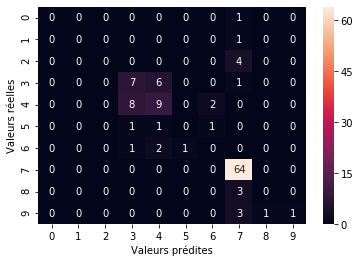

In [32]:
print("Matrice de Confusion avec le modèle de RandomForest")
gridRF=MatrixConfusion(gridModel,test_std,y_test, y_pred)

## 2. SVM 

In [33]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

#pca = PCA(n_components=4, svd_solver='randomized', whiten=True, random_state=42)
#svc = SVC(kernel='rbf', class_weight='balanced')
svc = SVC(kernel='rbf')
#model = make_pipeline(scale, svc)

In [34]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [1, 5, 10, 50,60,80,90,100], # model__parametre
    'gamma': [0.0001, 0.0005, 0.001, 0.005,0.008,0.02,0.04,0.6]
}

grid = GridSearchCV(svc, param_grid, cv=ShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 0))

%time grid.fit(train_std, y_train)
#print(grid.best_params_)

Wall time: 20.6 s


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.3, train_size=None),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 5, 10, 50, 60, 80, 90, 100],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.008, 0.02,
                                   0.04, 0.6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [35]:
model = grid.best_estimator_
model

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [36]:
model.score(train_std,y_train)

0.7362637362637363

In [37]:
y_pred = model.predict(test_std)

In [38]:
# evaluate model
gridSVC=EvaluateModel(model,test_std,y_test, y_pred)


               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       1.00      0.50      0.67        14
           4       0.58      1.00      0.73        19
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.82      1.00      0.90        64
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         5

    accuracy                           0.76       118
   macro avg       0.24      0.25      0.23       118
weighted avg       0.66      0.76      0.69       118



Matrice de Confusion avec le modèle de SVC et GridSearch


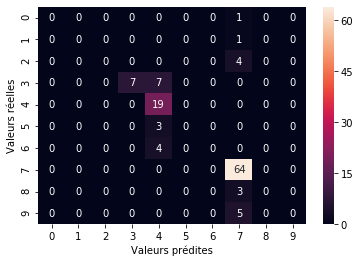

In [39]:
print("Matrice de Confusion avec le modèle de SVC et GridSearch")
matSVC = MatrixConfusion(model, test_std, y_test, y_pred)

## 3. LinearSVC

In [40]:
from sklearn.svm import LinearSVC
# Entraîner un classifieur linéaire (LinearSVC et SVC avec kernel='linear'. Quelle différence ?)
clf = LinearSVC(C=50,random_state=0,tol=1e-5)
clf.fit(train_std, y_train)

LinearSVC(C=50, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [41]:
clf.score(train_std,y_train)

0.9157509157509157

In [42]:
# evaluate model
linearSVC=EvaluateModel(clf,test_std,y_test, y_pred)


               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       1.00      0.50      0.67        14
           4       0.58      1.00      0.73        19
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.82      1.00      0.90        64
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         5

    accuracy                           0.76       118
   macro avg       0.24      0.25      0.23       118
weighted avg       0.66      0.76      0.69       118



Matrice de Confusion avec le modèle de LinearSVC


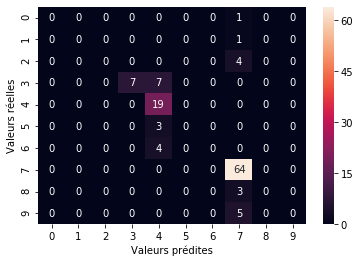

In [43]:
print("Matrice de Confusion avec le modèle de LinearSVC")
matLSVC=MatrixConfusion(clf,test_std,y_test, y_pred)

# 4. Naives bayes

In [44]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB

skf = StratifiedKFold(n_splits=10)
params = {}
gnb = GaussianNB()
nb = MultinomialNB()
gs = GridSearchCV(gnb, cv=skf, param_grid=params, return_train_score=True)

gs.fit(train_std,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [45]:
y_pred = gs.fit(train_std,y_train).predict(test_std)
print("Number of mislabeled points out of a total %d points : %d"
       % (test_std.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 118 points : 43


In [46]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.635593220338983


Matrice de Confusion avec le modèle de Naives Bayes


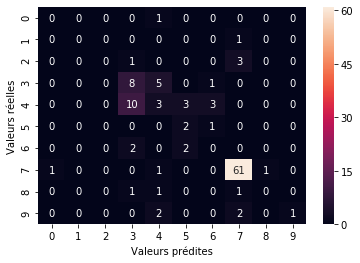

In [47]:
print("Matrice de Confusion avec le modèle de Naives Bayes")
matNaiBa=MatrixConfusion(gs,test_std,y_test, y_pred)

# 5. AdaBoost

In [48]:
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

ada = AdaBoostClassifier(n_estimators=300, learning_rate=0.01)
ada.fit(train_std,y_train)

Using TensorFlow backend.


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=300, random_state=None)

In [49]:
y_pred = ada.predict(test_std)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy est', accuracy)
print('Rapport de classification Adaboost')
print('\n',classification_report(y_test, y_pred))

Accuracy est 0.6016949152542372
Rapport de classification Adaboost

               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.24      0.43      0.31        14
           4       0.36      0.21      0.27        19
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.74      0.94      0.83        64
           9       0.00      0.00      0.00         3
          10       1.00      0.20      0.33         5

    accuracy                           0.60       118
   macro avg       0.23      0.18      0.17       118
weighted avg       0.53      0.60      0.54       118



Matrice de Confusion avec le modèle de AdaBoost


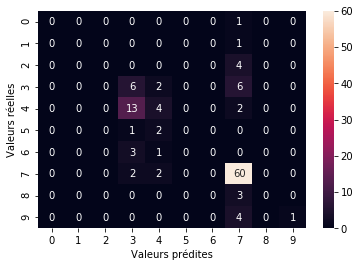

In [50]:
print("Matrice de Confusion avec le modèle de AdaBoost")
matAdB=MatrixConfusion(ada,test_std,y_test, y_pred)

# 6.ClusterCentroids

In [51]:
#Importations des librairies pour le rééchantillonnage
import numpy as np
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC # "Support vector classifier"

In [52]:
param_grid = {
    'C': [1, 5, 10, 50,60,80,90,100], # model__parametre
    'gamma': [0.0001, 0.0005, 0.001, 0.005,0.008,0.02,0.04,0.6]
}

grid = GridSearchCV(svc, param_grid, cv=ShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 0))


In [53]:
#Importation de la librarie
from imblearn.under_sampling import ClusterCentroids

# Sous-échantillonnage par calcul de centroïdes
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(train_std, y_train)

# Entraînement du modèle de SVM optimisé
grid.fit(X_cc, y_cc)

# Affichage des résultats
y_pred = grid.predict(test_std)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy est', accuracy)

print('Rapport de classification avec la méthode de sous échantillonnage de clustering')
print(classification_report_imbalanced(y_test, y_pred))

Accuracy est 0.6949152542372882
Rapport de classification avec la méthode de sous échantillonnage de clustering
                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00         1
          1       0.50      1.00      0.99      0.67      1.00      0.99         1
          2       0.00      0.00      0.95      0.00      0.00      0.00         4
          3       0.56      0.64      0.93      0.60      0.77      0.58        14
          4       0.64      0.47      0.95      0.55      0.67      0.43        19
          5       0.00      0.00      0.99      0.00      0.00      0.00         0
          6       0.20      0.33      0.97      0.25      0.57      0.30         3
          7       0.20      0.25      0.96      0.22      0.49      0.22         4
          8       0.90      0.89      0.89      0.90      0.89      0.79        64
          9       0.00      0.00      0.98      0.00     

Matrice de Confusion avec le modèle de ClusterCentroids


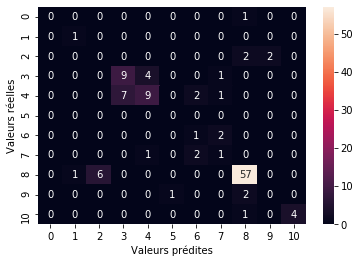

In [54]:
print("Matrice de Confusion avec le modèle de ClusterCentroids")
matClC=MatrixConfusion(cc,test_std,y_test, y_pred)